In [1]:
from gymnasium import Env
from gymnasium.spaces import Discrete, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3 import DQN

from typing import Optional

from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

In [2]:
elevatorNumber = 1
floor_number = 21
floorHeight = 6
elevatorSpeed = 6
elevatorCapacity = 4

floors_for_calls = floor_number - 1

# cikk 3
time_between_floors = 5
stop_time = 9 #7

In [3]:
class ElevatorEnv(Env):
    def __init__(self):
        # 3 actions: DOWN, STOP, UP
        self.action_space = Discrete(3) # available actions

        # ci
        #self.call_on_floors = np.random.randint(0,2,floors_for_calls)
        val = random.randint(1,floors_for_calls)
        self.call_on_floors = np.random.randint(0,1,floors_for_calls)
        self.call_on_floors[val-1] = 1
        # p
        self.position = 0 # random.randint(0, floors_for_calls) #Discrete(5) # 0-4 kozt melyik szinten van a lift
        # v mint velocity : -3, 0 vagy 3 --- 0 1 2
        self.velocity = 1 # random.randint(0, 2) # Discrete(3)
        self.occupacy = 0 # random.randint(0, floors_for_calls) # Discrete(4) # hany ember van a liftben

        #_max_episode_steps = 20

        calls = np.random.randint(2,3,floors_for_calls)
        others = [floor_number, 3 ,elevatorCapacity + 1]
        self.observation_space = MultiDiscrete(np.concatenate((calls, others))) #the state of the env, osszes megfigyeles ebbe
        # f1 ... fn position velocity occupacy ------ time
        

    # transition from one state to another
    def step(self, action):
        # Flag that marks the termination of an episode
        terminated = False # the environment terminating
        truncated = False # the episode truncating
        
        # info
        info = {}
        info['start_pos'] = self.position
        info['start_occ'] = self.occupacy

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        ## apply action
        if action == 0: # accelelrates DOWN
            u = -1
        elif action == 1: # accelerates UP
            u = 1
        elif action == 2: # STOP
            u = 0
        # time events between two floors
        velocity = 3 * u
        self.position = self.position + velocity / 3

        # change occupancy
        if (self.position > 0) and (velocity == 0) and (self.call_on_floors[(int)(self.position-1)] == 1) and (self.occupacy < elevatorCapacity):
            self.occupacy += 1
        elif (self.position == 0) and (velocity == 0):
            self.occupacy = 0
        # change calls accordingly
        for i in range(1, len(self.call_on_floors)+1):
            if self.position == i and velocity == 0 and self.occupacy < elevatorCapacity:
                self.call_on_floors[i-1] = 0
                break

        ## calculate reward
        reward = (float)(- (sum(self.call_on_floors)) - self.occupacy)

        ## arrival of new passangers
        values = list(np.arange(0, floor_number))
        #probs =  [0.829, 0.005, 0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.004]
        probs = [0.62, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01]
        #probs = [0.24, 0.02, 0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.02]
        #probs = [0.6875, 0.0625, 0.09375, 0.09375, 0.0625]
        e = np.random.choice(values, 1, p=probs)
        for i in range(1, len(self.call_on_floors)+1):
            if e == i:
                self.call_on_floors[i-1] = 1
                break

        if velocity == -3:
            self.velocity = 0
        elif velocity == 0:
            self.velocity = 1
        elif velocity == 3:
            self.velocity = 2

        ## end of action
        if reward == 0:
            terminated = True

        ## 
        if self.position > floors_for_calls:
            truncated = True
            terminated = False
            reward -= 100
            self.position = floors_for_calls
        elif self.position < 0:
            truncated = True
            terminated = False
            reward -= 100
            self.position = 0

        #############################
        if info.get('action') is not None:
            if action == 2:
                if info['action'] != 1:
                    reward -= -100
                    truncated = True
                    terminated = False
            if info['action'] == 2 and action != 0:
                reward -= -100
                truncated = True
                terminated = False
        '''
        else:
            if action == 2:
                reward -= 100
                truncated = True
                terminated = False
        '''

        info['end_pos'] = self.position
        info['end_occ'] = self.occupacy
        info['action'] = action
        info['reward'] = reward

        stuff = np.array([self.position, self.velocity, self.occupacy]).astype(int)
        rta = np.concatenate((self.call_on_floors, stuff))
        # Return step information
        return rta, reward, terminated, truncated, info
       
    def render(self):
        pass

    def reset(self, seed: Optional[int] = None):
        info = {}
        
        val = random.randint(1,floors_for_calls)
        self.call_on_floors = np.random.randint(0,1,floors_for_calls)
        self.call_on_floors[val-1] = 1
        #self.call_on_floors = np.random.randint(0,2,floors_for_calls)

        self.position = 0 #random.randint(0, 4)
        self.velocity = 1 #random.randint(0, 2)
        self.occupacy = 0 #random.randint(0, 4)

        stuff = np.array([self.position, self.velocity, self.occupacy]).astype(int)
        rta = np.concatenate((self.call_on_floors, stuff))
        return rta, info

In [4]:
env = ElevatorEnv()
check_env(env, warn=True)

In [5]:
###### n-times to the ground floor with passangers

def add_wait_time(waiting_times, time, obs):
    for i in range(0, len(obs[0])-3): 
        if obs[0][i] == 1:
            waiting_times[i] += time
        return waiting_times

def iterate_over(model, arrival_number):
    env = model.get_env()
    obs = env.reset()

    waiting_times = [0] * (len(obs[0])-3)
    waits = []
    
    system_times = []
    sys_times = []

    arrivals = 0

    while arrivals != arrival_number:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        if action == 1: # UP
            waiting_times = add_wait_time(waiting_times, time_between_floors, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
        elif action == 0: # DOWN
            waiting_times = add_wait_time(waiting_times, time_between_floors, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
        elif action == 2: # STOP
            waiting_times = add_wait_time(waiting_times, stop_time, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
            floor = obs[0][-3]
            if floor == 0: # letesz
                if info[0]['start_occ'] > 0:
                    arrivals += 1
                    sys_times.append(np.mean(system_times))
                    system_times = []
            else: # felvesz
                if info[0]['start_occ'] < info[0]['end_occ']:
                    system_times.append(waiting_times[floor - 1])
                    waits.append(waiting_times[floor - 1])
                    waiting_times[floor - 1] = 0
    return np.mean(sys_times), np.mean(waits)

TESTING

In [ ]:
model_PPO = PPO("MlpPolicy", env, verbose=1)

In [ ]:
model_PPO.learn(total_timesteps=10000)

In [33]:
env = model_PPO.get_env()
obs = env.reset()
it = 0
print(obs)

start_positions = []
start_occupacies = []
end_positions = []
end_occupacies = []
actions = []
rewards = []
observations = []

aa = 1

rewards = []

while True:
    action, _states = model_PPO.predict(obs)
    obs, reward, done, info = env.step(action)
    #n_state, reward, done, info, st = env.step(action)

    start_positions.append(info[0]['start_pos'])
    start_occupacies.append(info[0]['start_occ'])
    end_positions.append(info[0]['end_pos'])
    end_occupacies.append(info[0]['end_occ'])
    actions.append(info[0]['action'])
    rewards.append(info[0]['reward'])
    observations.append(obs)

    aa += 1

    if aa > 1000:
        break

    it += 1
    if done: 
        print('obs', obs)
        print('rewards', reward)
        print('done', done)
        print('info', info)
        break
print(it)
print(obs)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]]
obs [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]
rewards [-124.]
done [ True]
info [{'start_pos': 20.0, 'start_occ': 4, 'end_pos': 20, 'end_occ': 4, 'action': 1, 'reward': -124.0, 'episode': {'r': -14147.0, 'l': 818, 't': 4092.999908}, 'TimeLimit.truncated': True, 'terminal_observation': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, 20,  2,  4])}]
818
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]


TESTING

In [36]:
del model_PPO

In [35]:
model_PPO = PPO("MlpPolicy", env, verbose=1)

Using cpu device


In [273]:
model_PPO.learn(total_timesteps=100000)

-----------------------------
| time/              |      |
|    fps             | 1487 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 966          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0045765266 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.588        |
|    learning_rate        | 0.0003       |
|    loss                 | 101          |
|    n_updates            | 5390         |
|    policy_gradient_loss | -0.00395     |
|    value_loss           | 256          |
------------------------------------------
----------------

In [274]:

system_t = []
wait_t = []
for i in range (0, 10):
    system_time, wait_time = iterate_over(model_PPO, 10)
    system_t.append(system_time)
    wait_t.append(wait_time)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")


68.06027777777778 mean system time
16.730805555555555 mean wait time


PPO

In [ ]:

#model_PPO = PPO("MlpPolicy", env, learning_rate=0.0003, n_steps=2048, gamma=0.99, verbose=0) # alapértelmezett
model_PPO = PPO("MlpPolicy", env, learning_rate=0.003, n_steps=2048, gamma=0.99, verbose=0) # magasabb tanulasai rata
#model_PPO = PPO("MlpPolicy", env, learning_rate=0.0003, n_steps=4096, gamma=0.99, verbose=0) # tobb lepes
#model_PPO = PPO("MlpPolicy", env, learning_rate=0.003, n_steps=4096, gamma=0.99, verbose=0) # magasabb tanulasi rata es tobb lepes

maxi = 10
learning_steps = 100000

system_t = []
wait_t = []
for i in range(0, maxi):
    model_PPO.learn(total_timesteps=learning_steps)
    print(i, "learned")
    s_t = []
    w_t = []
    for j in range (0, 10):
        system_time, wait_time = iterate_over(model_PPO, 10)
        s_t.append(system_time)
        w_t.append(wait_time)
    system_t.append(np.mean(s_t))
    wait_t.append(np.mean(w_t))
    print(i, "iterated", np.mean(s_t))

elevator_path = os.path.join('Training', 'Models-20', 'PPO-2')
model_PPO.save(elevator_path)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")

xarray2 = []
for i in range(1, maxi + 1):
    xarray2.append(learning_steps * i)

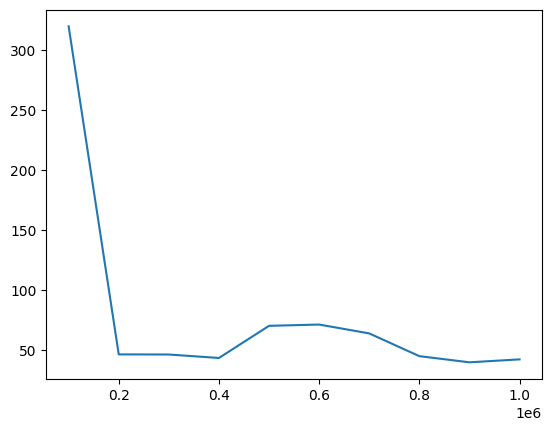

39.52583333333334 319.8541666666667
[319.8541666666667, 46.13, 46.0275, 43.15, 69.96166666666667, 71.03583333333333, 63.625, 44.65500000000001, 39.52583333333334, 41.97416666666667]


In [58]:
# system time

xpoints = np.array(xarray2)
ypoints = np.array(system_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(system_t), max(system_t))
print(system_t)

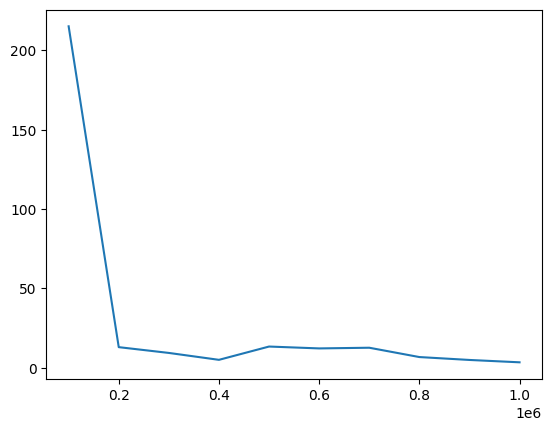

3.4648315452663274 214.99147470176885
[214.99147470176885, 13.009615384615383, 9.369851792943898, 5.023045665634674, 13.389645826533691, 12.214995702047762, 12.64483426704015, 6.774331002331001, 4.949697712418301, 3.4648315452663274]


In [59]:
# wait time for elevator

xpoints = np.array(xarray2)
ypoints = np.array(wait_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(wait_t), max(wait_t))
print(wait_t)

In [60]:

print( xarray2 )
print("system time")
print( (np.around(system_t,2)) )
print("wait time for elevator")
print( (np.around(wait_t,2)) )


[100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
system time
[319.85  46.13  46.03  43.15  69.96  71.04  63.62  44.66  39.53  41.97]
wait time for elevator
[214.99  13.01   9.37   5.02  13.39  12.21  12.64   6.77   4.95   3.46]


DQN

In [ ]:
del model_DQN

In [266]:
model_DQN.learn(total_timesteps=10000)

In [ ]:
s = []
w = []
for j in range (0, 10):
    system_time, wait_time = iterate_over(model_DQN, 10)
    s.append(system_time)
    w.append(wait_time)
    print(j)

In [264]:
print(np.mean(s))
print(np.mean(w))

3785.501666666666
2812.6475136943664


In [6]:

#model_DQN = DQN("MlpPolicy", env, learning_rate=0.0001, exploration_initial_eps=1, exploration_final_eps=0.05, verbose=0) # alapértelmezett
model_DQN = DQN("MlpPolicy", env, learning_rate=0.38, exploration_initial_eps=0.8, exploration_final_eps=0.89, verbose=0) # cikkben

maxi = 10
learning_steps = 200000

system_t = []
wait_t = []
for i in range (0, maxi):
    model_DQN.learn(total_timesteps=learning_steps)
    print(i,  "learned")
    s_t = []
    w_t = []
    for j in range (0, 10):
        system_time, wait_time = iterate_over(model_DQN, 10)
        s_t.append(system_time)
        w_t.append(wait_time)
    system_t.append(np.mean(s_t))
    wait_t.append(np.mean(w_t))
    print(i, "iterated")

elevator_path = os.path.join('Training', 'Models-20', 'DQN-2')
model_DQN.save(elevator_path)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")

xarray2 = []
for i in range(1, maxi + 1):
    xarray2.append(learning_steps * i)

0 learned
0 iterated
1 learned
1 iterated
2 learned
2 iterated
3 learned
3 iterated
4 learned
4 iterated
5 learned
5 iterated
6 learned
6 iterated
7 learned
7 iterated
8 learned
8 iterated
9 learned
9 iterated

1676.035499216531 mean system time
90.99245628106073 mean wait time


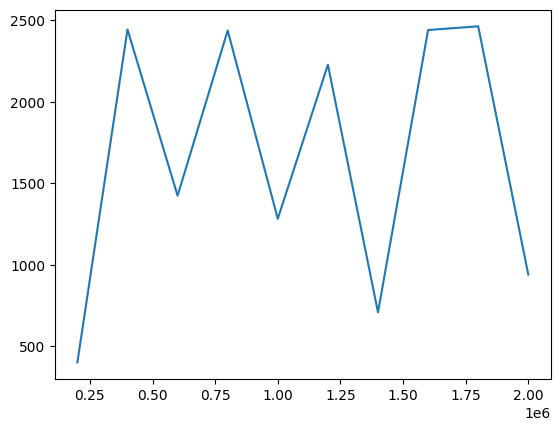

401.4517661603103 2462.0245587829413
[401.4517661603103, 2442.5465299445473, 1423.0984451102072, 2436.285226121182, 1281.9375461538461, 2226.3566525986876, 707.9645460536196, 2439.2436047351284, 2462.0245587829413, 939.4461165048402]


In [7]:
# system time

xpoints = np.array(xarray2)
ypoints = np.array(system_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(system_t), max(system_t))
print(system_t)

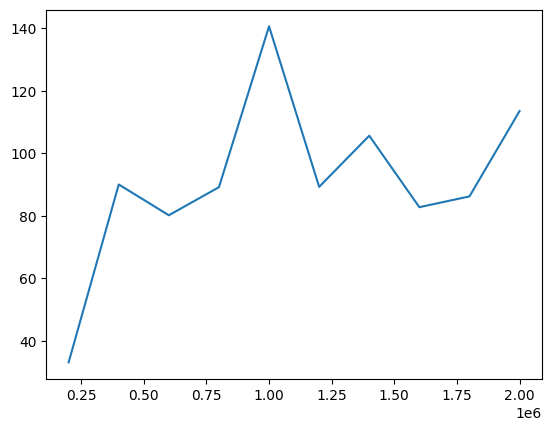

33.131574877126596 140.52033188385045
[33.131574877126596, 89.97513840239995, 80.12919540019195, 89.10431959383195, 140.52033188385045, 89.21225418548346, 105.55276445667843, 82.71178457997817, 86.15430600590547, 113.43289342516087]


In [8]:
# wait time for elevator

xpoints = np.array(xarray2)
ypoints = np.array(wait_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(wait_t), max(wait_t))
print(wait_t)

In [10]:

print( xarray2 )
print("system time")
print( (np.around(system_t,2)) )
print("wait time for elevator")
print( (np.around(wait_t,2)) )


[200000, 400000, 600000, 800000, 1000000, 1200000, 1400000, 1600000, 1800000, 2000000]
system time
[ 401.45 2442.55 1423.1  2436.29 1281.94 2226.36  707.96 2439.24 2462.02
  939.45]
wait time for elevator
[ 33.13  89.98  80.13  89.1  140.52  89.21 105.55  82.71  86.15 113.43]


x

In [166]:
del model_PPO

In [167]:
model_PPO = PPO("MlpPolicy", env, learning_rate=0.003, n_steps=2048, gamma=0.99, verbose=0)

In [168]:
model_PPO.learn(total_timesteps=1000)

In [126]:

model = model_PPO
env = model.get_env()
obs = env.reset()

arrival_number = 10
arrivals = 0

it = 0
its = []

up = 0
down = 0
stop = 0
pickup = 0

rewards = []

while arrivals != arrival_number:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)

    rewards.append(reward[0])

    it += 1
    if action == 1:
        up += 1
    if action == 0:
        down += 1
    if action == 2: # STOP
        stop +=1
        floor = obs[0][-3]
        if floor == 0: # arrival
            if info[0]['start_occ'] > 0:
                arrivals += 1
                its.append(it)
                it = 0
        else: # pick up passanger
            if (info[0]['start_occ'] <  info[0]['end_occ']):
                pickup += 1

print(up, down, stop)
print(np.mean(its))
print(pickup)

1054 1069 438
256.1
15


In [128]:
values, counts = np.unique(np.array(rewards), return_counts=True)
print(values)
print(counts)

[-120. -119. -118. -117. -116. -115. -114. -101.  -20.  -19.  -18.  -17.
  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.
   -4.   -3.   -2.   -1.]
[  1   1   2   3   3   3   1   1   5 112  65 132 141 222 175 114 182 127
 261 154 140 123  85 114 132  50  73 139]


In [ ]:
obs